In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from time import time

In [4]:
# 读取球队比赛数据
def load_dict_from_file_team_season(filepath):
    _dict = {}
    count = 0
    key = []
    try:
        with open(filepath, 'r') as dict_file:
            for line in dict_file:
                if count == 0:
                    key = line.strip().split(',')
                    key[3] = 'PTS1'
                    key[5] = 'PTS2'
                    key[6] = '1'
                    key[7] = '2'
                    count += 1
                    for i in range(len(key)):
                        _dict[key[i]] = []
                    # print(_dict)
                else:
                    value = line.strip().split(',')
                    # print(line)
                    # print(value)
                    for i in range(len(key)):
                        # print(i)
                        _dict[key[i]].append(value[i].strip())
                # (key, value) = line.strip().split(',')
                # _dict[key] = value
    except IOError as ioerr:
        print("文件 %s 不存在" % filepath)
    _dict = pd.DataFrame(_dict)
    return _dict

In [5]:
# 读取球队排名数据
def load_dict_from_file_team_ranking(filepath):
    _dict = {}
    count = 0
    key = []
    try:
        with open(filepath, 'r') as dict_file:
            for line in dict_file:
                if count == 0:
                    key = line.strip().split(',')
                    for i in range(len(key)):
                        _dict[key[i]] = []
                    count += 1
                    # print(_dict)
                else:
                    value = line.strip().split(',')
                    for i in range(len(key)):
                        _dict[key[i]].append(value[i].strip())
                # (key, value) = line.strip().split(',')
                # _dict[key] = value
    except IOError as ioerr:
        print("文件 %s 不存在" % filepath)
    _dict = pd.DataFrame(_dict)
    return _dict

In [6]:
# 计算常规赛天数
def cauculate_day(dataset):
    Day = []
    label = int((dataset['Date'][0].strip().split(' '))[2])
    for i in range(len(dataset['Date'])):
        day = 1
        sign = dataset['Date'][i].strip().split(' ')
        if sign[1] == 'Nov':
            day += 31
        elif sign[1] == 'Dec':
            day += 61
        elif sign[1] == 'Jan':
            day += 92
        elif sign[1] == 'Feb':
            day += 123
        elif sign[1] == 'Mar':
            day += 151
        elif sign[1] == 'Apr':
            day += 182
        elif sign[1] == 'May':
            day += 212
        elif sign[1] == 'Jun':
            day += 243
        # print(int(sign[2]) - label + day)
        Day.append(int(sign[2]) - label + day)
    dataset['Day'] = Day
    return

In [7]:
# 计算累计得分
def points_gain(dataset, name_home):
    score = {}
    h_p = []
    v_p = []
    pts_add = {}
    home = []
    visit = []
    for i in range(len(name_home)):
        pts_add[name_home[i]] = 0
        score[name_home[i]] = 0
    # print(score)
    for i in range(len(dataset.index)):
        # 计算每场净胜分
        pts = dataset['PTS2'][i] - dataset['PTS1'][i]
        pts_add[dataset['Home'][i]] += pts
        pts_add[dataset['Visitor'][i]] -= pts

        # 计算每场积分，获胜积1分，输了积0分
        if dataset['HW'][i] == 1:
            score[dataset['Home'][i]] += 1
        else:
            score[dataset['Visitor'][i]] += 1
        h_p.append(score[dataset['Home'][i]])
        v_p.append(score[dataset['Home'][i]])
        home.append(pts_add[dataset['Home'][i]])
        visit.append(pts_add[dataset['Visitor'][i]])
    dataset['h_pts_add'] = home
    dataset['v_pts_add'] = visit
    dataset['h_score_add'] = h_p
    dataset['v_score_add'] = v_p
    return

In [8]:
# 计算主客场最近三场表现
def recent_behavior(dataset, name_home):
    prew = {}
    for i in range(len(name_home)):
        prew[name_home[i]] = []
    hm1 = []
    vm1 = []
    hm2 = []
    vm2 = []
    hm3 = []
    vm3 = []
    for i in range(len(dataset.index)):
        hteam = dataset['Home'][i]
        vteam = dataset['Visitor'][i]
        if len(prew[hteam]) >= 3:
            hm3.append(prew[hteam][-3])
            hm2.append(prew[hteam][-2])
            hm1.append(prew[hteam][-1])
        elif len(prew[hteam]) >= 2:
            hm3.append('N')
            hm2.append(prew[hteam][-2])
            hm1.append(prew[hteam][-1])
        elif len(prew[hteam]) >= 1:
            hm3.append('N')
            hm2.append('N')
            hm1.append(prew[hteam][-1])
        else:
            hm3.append('N')
            hm2.append('N')
            hm1.append('N')

        if len(prew[vteam]) >= 3:
            vm3.append(prew[vteam][-3])
            vm2.append(prew[vteam][-2])
            vm1.append(prew[vteam][-1])
        elif len(prew[vteam]) >= 2:
            vm3.append('N')
            vm2.append(prew[vteam][-2])
            vm1.append(prew[vteam][-1])
        elif len(prew[vteam]) >= 1:
            vm3.append('N')
            vm2.append('N')
            vm1.append(prew[vteam][-1])
        else:
            vm3.append('N')
            vm2.append('N')
            vm1.append('N')

        if dataset['HW'][i] == 1:
            prew[hteam].append(1)
            prew[vteam].append(0)
        else:
            prew[vteam].append(1)
            prew[hteam].append(0)
    dataset['hm1'] = hm1
    dataset['hm2'] = hm2
    dataset['hm3'] = hm3
    dataset['vm1'] = vm1
    dataset['vm2'] = vm2
    dataset['vm3'] = vm3
    return

In [9]:
# 计算比赛周
def cauculate_week(dataset):
    week = []
    for i in range(len(dataset.index)):
        w = dataset['Day'][i] // 7 + 1
        week.append(w)
    dataset['Week'] = week
    return

In [10]:
# 计算周平均值
def pts_ave_week(dataset):
    dataset['hPTS_avew'] = (dataset['h_pts_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    dataset['vPTS_avew'] = (dataset['v_pts_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    dataset['hSco_avew'] = (dataset['h_score_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    dataset['vSco_avew'] = (dataset['h_score_add'].apply(float) / dataset['Week'].apply(float)).round(2)
    return

In [11]:
# 删去前几周对球队比赛胜负统计不完全的数据
def delete_somedata(dataset):
    print(~dataset['hm3'].isin(['N']))
    dataset = dataset[~dataset['hm3'].isin(['N'])]
    dataset = dataset[~dataset['vm3'].isin(['N'])]
    return

In [12]:
# 归一化
def convert_1(data):
    data_list = list(data)
    # print(data_list)
    Max = max(data_list)
    Min = min(data_list)
    # print(Max)
    # print(Min)
    return (data - Min) / (Max - Min)

In [13]:
# 得到球队的特征
def get_feature_team(dataset):
    dict = {}
    dataset['MOV/A'] = dataset['MOV/A'].apply(float)
    dataset['ORtg/A'] = dataset['ORtg/A'].apply(float)
    dataset['DRtg/A'] = dataset['DRtg/A'].apply(float)
    dataset['NRtg/A'] = dataset['NRtg/A'].apply(float)
    for i in range(len(dataset.index)):
        dict[dataset['Team'][i]] = []
        dict[dataset['Team'][i]].append(dataset['MOV/A'][i])
        dict[dataset['Team'][i]].append(dataset['ORtg/A'][i])
        dict[dataset['Team'][i]].append(dataset['DRtg/A'][i])
        dict[dataset['Team'][i]].append(dataset['NRtg/A'][i])
    return dict

In [14]:
# 将球队特征加入data中
def insert_features(dataset, dic):
    hMOV = []
    hORtg = []
    hDRtg = []
    hNRtg = []
    vMOV = []
    vORtg = []
    vDRtg = []
    vNRtg = []
    # print(dic)
    for i in range(len(dataset.index)):
        hteam = dataset['Home'][i]
        vteam = dataset['Visitor'][i]
        hMOV.append(dic[hteam][0])
        hORtg.append(dic[hteam][1])
        hDRtg.append(dic[hteam][2])
        hNRtg.append(dic[hteam][3])
        vMOV.append(dic[vteam][0])
        vORtg.append(dic[vteam][1])
        vDRtg.append(dic[vteam][2])
        vNRtg.append(dic[vteam][3])
    dataset['hMOV'] = hMOV
    dataset['hORtg'] = hORtg
    dataset['hDRtg'] = hDRtg
    dataset['hNRtg'] = hNRtg
    dataset['vMOV'] = vMOV
    dataset['vORtg'] = vORtg
    dataset['vDRtg'] = vDRtg
    dataset['vNRtg'] = vNRtg
    return

In [17]:
# 球队比赛数据总处理
def data_operate(data, data_team):
    data = data.drop(['1', '2'], axis=1)
    data.rename(columns={'Visitor/Neutral': 'Visitor', 'Home/Neutral': 'Home'}, inplace=True)
    name_home = data['Home'].unique()
    data['HW'] = ((data['PTS2'].apply(float) - data['PTS1'].apply(float)) > 0).apply(int)
    data['PTS1'] = data['PTS1'].apply(int)
    data['PTS2'] = data['PTS2'].apply(int)
    cauculate_day(data)
    # print(name_home)
    points_gain(data, name_home)
    recent_behavior(data, name_home)
    cauculate_week(data)
    pts_ave_week(data)
    # delete_somedata(data2017)
    data = data[~data['hm3'].isin(['N'])]
    data = data[~data['vm3'].isin(['N'])]
    data.reset_index(inplace=True, drop=True)

    team_dict = get_feature_team(data_team)
    # print(team_dict)
    insert_features(data, team_dict)

    # 归一化
    str_convrt = ['hPTS_avew', 'vPTS_avew', 'hMOV', 'hNRtg', 'vMOV', 'vNRtg']
    for i in str_convrt:
        data[i] = convert_1(data[i])

    cols = ['hPTS_avew', 'vPTS_avew', 'hMOV', 'hNRtg', 'vMOV', 'vNRtg', 'hSco_avew', 'vSco_avew']
    for col in cols:
        data[col] = scale(data[col])

    # 构建最终用于训练的特征：
    feature = ['hm1', 'hm2', 'hm3', 'vm1', 'vm2', 'vm3', 'hPTS_avew', 'vPTS_avew', 'hSco_avew', 'vSco_avew', 'hMOV',
               'hNRtg', 'vMOV', 'vNRtg']
    X_feature = data[feature]
    y_label = data['HW']

    # 去掉相关性较大的特征
    # X_feature = X_feature.drop(['vSco_avew', 'vMOV', 'hMOV', 'vPTS_avew'], axis=1)

    # 构建皮尔逊相关热力图
    # plt.rcParams['font.sans-serif']=['SimHei']
    # plt.rcParams['axes.unicode_minus']=False
    # train_data=pd.concat([X_feature,y_label],axis=1)
    # colormap = plt.cm.RdBu
    # plt.figure(figsize=(21,18))
    # plt.title('Pearson Correlation of Features', y=1.05, size=15)
    # sns.heatmap(train_data.astype(float).corr(),linewidths=0.1,vmax=1.0,
    #             square=True, cmap=colormap, linecolor='white', annot=True)
    # plt.show()
    train_data = pd.concat([X_feature, y_label], axis=1)
    for i in list(train_data):
        train_data[i] = train_data[i].apply(float)
    return train_data

In [18]:
dataset = {}
teamset ={}
result ={}

# 得到每年的处理数据
for i in range(2015,2018):
    str1 = 'team_season_'+str(i)+'.txt'
    str2 = 'team_'+str(i)+'.txt'
    dataset[i] = load_dict_from_file_team_season(str1)
    teamset[i] = load_dict_from_file_team_ranking(str2)
    result[i] = data_operate(dataset[i], teamset[i])

res = result[2015]

# 合并数据
for i in range(2016,2018):
    # print(res.info())
    # print(result[i].info())
    res = pd.merge(res, result[i], how='outer')

# 划分特征集和标签
y_label = res['HW']
X_feature = res.drop(['HW'],axis =1)

# 划分训练集和测试集
Train_data, Test_data, Train_y, Test_y = train_test_split(X_feature, y_label, test_size=0.2)

# 利用SVM进行分类
#from sklearn import svm
#print('SVM运行结果：')
#t0 = time()
#clf = svm.SVC(C=10, kernel='linear', decision_function_shape='ovr')
#clf.fit(Train_data, Train_y, sample_weight=None)
#acc1 = clf.predict(Train_data) == list(Train_y)
#print('Accuracy_train:%f' % (np.mean(acc1)))
#acc2 = clf.predict(Test_data) == list(Test_y)
#print('Accuracy_test:%f' % (np.mean(acc2)))
#t = time() - t0
#print("%s :\t%.2fs" % ('共耗时：', t))

# # 逻辑斯蒂回归学习结果
print('逻辑回归运行结果：')
t0 = time()
import sklearn.linear_model as sl
logitmodel=sl.LogisticRegression()#定义回归模型
logitmodel.fit(Train_data,Train_y)#训练模型
# print(classification_report(y_test,logitmodel.predict(x_test)))
# print(classification_report(Test_y,logitmodel.predict(Test_data)))
acc1 = logitmodel.predict(Train_data) == list(Train_y)
print('Accuracy_train:%f' % (np.mean(acc1)))
acc2 = logitmodel.predict(Test_data) == list(Test_y)
print('Accuracy_test:%f' % (np.mean(acc2)))
t = time() - t0
print("%s :\t%.2fs" % ('共耗时：', t))

print(Train_data)
print(Train_y)
print(logitmodel.predict(Train_data))


逻辑回归运行结果：
Accuracy_train:0.702373
Accuracy_test:0.690382
共耗时： :	0.02s
      hm1  hm2  hm3  vm1  vm2  vm3  hPTS_avew  vPTS_avew  hSco_avew  \
297   0.0  0.0  0.0  1.0  0.0  0.0  -0.842364   0.655671  -0.722930   
2903  1.0  1.0  0.0  0.0  1.0  0.0   0.038291  -1.416473   0.300958   
3254  1.0  1.0  1.0  0.0  0.0  0.0   0.158166   0.620336   0.310465   
2160  1.0  0.0  0.0  1.0  0.0  0.0   0.550346   0.042468   0.370632   
1655  0.0  1.0  1.0  1.0  0.0  0.0   0.005622   0.504710   0.030434   
...   ...  ...  ...  ...  ...  ...        ...        ...        ...   
3746  1.0  1.0  1.0  1.0  1.0  1.0   0.456549   1.734449   0.631355   
2974  1.0  1.0  0.0  0.0  1.0  1.0  -0.002520  -0.439746  -0.082571   
3699  1.0  1.0  1.0  1.0  1.0  0.0   1.615166  -0.095327   1.687834   
1424  0.0  1.0  0.0  1.0  1.0  1.0   0.440916   0.270008   0.450854   
3592  1.0  1.0  1.0  1.0  0.0  1.0   0.075139  -0.232333  -0.157907   

      vSco_avew      hMOV     hNRtg      vMOV     vNRtg  
297   -0.722930 -0.

原始特征数量: 14
特征示例: ['hm1', 'hm2', 'hm3', 'vm1', 'vm2']...

PCA降维后特征数量: 8
累计解释方差比例: 0.9598


/tmp/ipython-input-3440101317.py:79: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3440101317.py:79: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


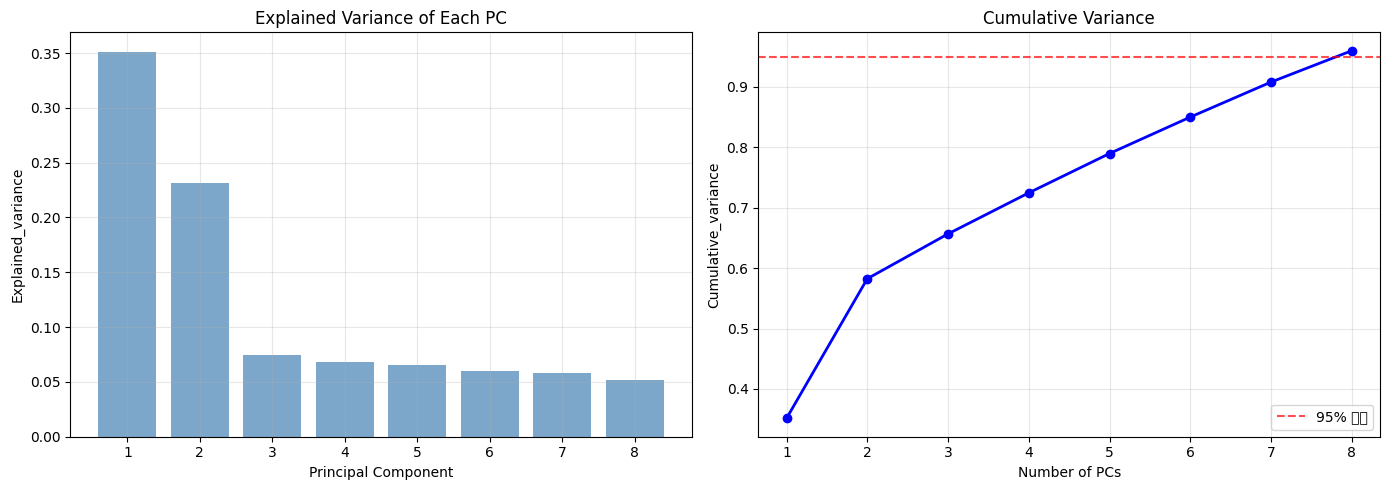


PCA转换完成，使用前8个主成分
训练集形状: (3034, 8)
测试集形状: (759, 8)

逻辑回归运行结果（使用PCA降维后特征）：
训练集准确率: 0.6889
测试集准确率: 0.7207
共耗时： :	0.03s

对比：不使用PCA的逻辑回归性能
原始特征数量: 14
训练集准确率: 0.6948
测试集准确率: 0.7115
共耗时： :	0.02s

部分训练数据（PCA转换后）:
           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
3366  1.663220  0.468388 -0.572052  0.632931 -1.433654 -0.095577  1.421023   
3267  0.628916 -2.086959  0.142562 -0.097323 -0.338618  0.602088  1.737251   
1436  2.272575  3.981602  0.310299  1.216265  0.879277 -0.997591 -0.718741   
937   1.419243  2.941631  1.476059 -1.739194  0.237294  0.048384 -0.606768   
108  -2.406368  0.803360 -0.713482  0.629211 -1.340653 -0.515238 -0.188056   

           PC8  
3366  0.180785  
3267  0.138947  
1436 -0.887036  
937  -1.033926  
108  -1.224507  

训练标签:
3366    1.0
3267    0.0
1436    0.0
937     1.0
108     1.0
Name: HW, dtype: float64

模型预测:
[1. 1. 1. 1. 0.]


In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dataset = {}
teamset ={}
result ={}

# 得到每年的处理数据
for i in range(2015,2018):
    str1 = 'team_season_'+str(i)+'.txt'
    str2 = 'team_'+str(i)+'.txt'
    dataset[i] = load_dict_from_file_team_season(str1)
    teamset[i] = load_dict_from_file_team_ranking(str2)
    result[i] = data_operate(dataset[i], teamset[i])

res = result[2015]

# 合并数据
for i in range(2016,2018):
    res = pd.merge(res, result[i], how='outer')

# 划分特征集和标签
y_label = res['HW']
X_feature = res.drop(['HW'],axis =1)

# 划分训练集和测试集
Train_data, Test_data, Train_y, Test_y = train_test_split(X_feature, y_label, test_size=0.2, random_state=42)

# ============ 添加PCA特征筛选 ============
# 保存原始特征名（用于后续分析）
original_features = Train_data.columns.tolist()
print(f"原始特征数量: {len(original_features)}")
print(f"特征示例: {original_features[:5]}...")

# 1. 标准化数据（PCA对数据尺度敏感）
scaler = StandardScaler()
Train_data_scaled = scaler.fit_transform(Train_data)
Test_data_scaled = scaler.transform(Test_data)

# 2. 应用PCA
# 方法1：保留95%的方差（自动选择主成分数量）
pca = PCA(n_components=0.95, random_state=42)
Train_data_pca = pca.fit_transform(Train_data_scaled)
Test_data_pca = pca.transform(Test_data_scaled)

# 3. 打印PCA信息
print(f"\nPCA降维后特征数量: {pca.n_components_}")
print(f"累计解释方差比例: {sum(pca.explained_variance_ratio_):.4f}")

# 可视化累计解释方差
def plot_pca_variance(pca_model):
    plt.figure(figsize=(10, 6))

    # 解释方差比例
    explained_variance = pca_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # 创建子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # 子图1：单个主成分解释方差
    ax1.bar(range(1, len(explained_variance) + 1), explained_variance,
            alpha=0.7, color='steelblue')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained_variance')
    ax1.set_title('Explained Variance of Each PC')
    ax1.grid(True, alpha=0.3)

    # 子图2：累计解释方差
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'b-', marker='o', linewidth=2)
    ax2.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% 阈值')
    ax2.set_xlabel('Number of PCs')
    ax2.set_ylabel('Cumulative_variance')
    ax2.set_title('Cumulative Variance')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 可选：显示PCA可视化
plot_pca_variance(pca)

# 4. 将PCA结果转换为DataFrame（保持数据格式一致）
Train_data_pca_df = pd.DataFrame(
    Train_data_pca,
    columns=[f'PC{i+1}' for i in range(Train_data_pca.shape[1])],
    index=Train_data.index
)
Test_data_pca_df = pd.DataFrame(
    Test_data_pca,
    columns=[f'PC{i+1}' for i in range(Test_data_pca.shape[1])],
    index=Test_data.index
)

# 更新训练和测试数据为PCA转换后的数据
Train_data = Train_data_pca_df
Test_data = Test_data_pca_df

print(f"\nPCA转换完成，使用前{pca.n_components_}个主成分")
print(f"训练集形状: {Train_data.shape}")
print(f"测试集形状: {Test_data.shape}")
# ============ PCA结束 ============

# 逻辑斯蒂回归学习结果
print('\n逻辑回归运行结果（使用PCA降维后特征）：')
t0 = time()
import sklearn.linear_model as sl
logitmodel = sl.LogisticRegression(random_state=42)  # 定义回归模型
logitmodel.fit(Train_data, Train_y)  # 训练模型
t = time() - t0

train_predictions = logitmodel.predict(Train_data)
test_predictions = logitmodel.predict(Test_data)

# 训练集和测试集准确率
acc1 = train_predictions == list(Train_y)
print('训练集准确率: %.4f' % (np.mean(acc1)))
acc2 = test_predictions== list(Test_y)
print('测试集准确率: %.4f' % (np.mean(acc2)))

print("%s :\t%.2fs" % ('共耗时：', t))

def compare_without_pca(X_train, X_test, y_train, y_test):
    """比较不使用PCA的逻辑回归性能"""
    print("\n" + "="*50)
    print("对比：不使用PCA的逻辑回归性能")
    print("="*50)

    # 标准化数据
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    t0 = time()
    # 训练逻辑回归模型
    logitmodel_no_pca = sl.LogisticRegression(random_state=42, max_iter=1000)
    logitmodel_no_pca.fit(X_train_scaled, y_train)
    t = time() - t0

    # 计算准确率
    train_acc = logitmodel_no_pca.score(X_train_scaled, y_train)
    test_acc = logitmodel_no_pca.score(X_test_scaled, y_test)

    print(f"原始特征数量: {X_train.shape[1]}")
    print(f"训练集准确率: {train_acc:.4f}")
    print(f"测试集准确率: {test_acc:.4f}")
    print("%s :\t%.2fs" % ('共耗时：', t))

    return logitmodel_no_pca

# 可选：运行对比（需要原始数据）
# 注意：这里需要保存原始数据或重新加载
Train_data_original, Test_data_original, Train_y, Test_y = train_test_split(X_feature, y_label, test_size=0.2, random_state=42)
compare_without_pca(Train_data_original, Test_data_original, Train_y, Test_y)

# 打印部分数据（可选）
print("\n部分训练数据（PCA转换后）:")
print(Train_data.head())
print("\n训练标签:")
print(Train_y.head())
print("\n模型预测:")
print(logitmodel.predict(Train_data.head()))

In [37]:
# ============ 保存预测结果到文件 ============
import os
from datetime import datetime

# 创建结果保存目录
output_dir = 'prediction_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 生成时间戳
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. 保存训练集预测结果
train_results = pd.DataFrame({
    'Index': Train_data.index,
    'True_Label': Train_y.values,
    'Predicted_Label': train_predictions,
    'Is_Correct': train_predictions == Train_y.values
})

train_filename = f'{output_dir}/train_predictions_{timestamp}.csv'
train_results.to_csv(train_filename, index=False)
print(f"\n训练集预测结果已保存到: {train_filename}")
print(f"训练集记录数: {len(train_results)}")

# 2. 保存测试集预测结果
test_results = pd.DataFrame({
    'Index': Test_data.index,
    'True_Label': Test_y.values,
    'Predicted_Label': test_predictions,
    'Is_Correct': test_predictions == Test_y.values
})

test_filename = f'{output_dir}/test_predictions_{timestamp}.csv'
test_results.to_csv(test_filename, index=False)
print(f"测试集预测结果已保存到: {test_filename}")
print(f"测试集记录数: {len(test_results)}")


训练集预测结果已保存到: prediction_results/train_predictions_20251210_232233.csv
训练集记录数: 3034
测试集预测结果已保存到: prediction_results/test_predictions_20251210_232233.csv
测试集记录数: 759
